# Model training

This file contains main models and their training

## Table of content

- [Model training](#model-training)
  - [Table of content](#table-of-content)
  - [Loading libs and files](#loading-libs-and-files)
  - [Model](#model)
  - [Dropping unused data](#dropping-unused-data)
  - [Extract time features](#extract-time-features)
  - [Correlation](#correlation)
  - [Final result](#final-result)

## Loading libs and files

In [1]:
import eli5
import numpy as np
import pandas as pd
from prettytable                import PrettyTable
from xgboost                    import XGBRegressor
from sklearn.utils              import shuffle
from matplotlib                 import pyplot as plt
from eli5.sklearn               import PermutationImportance
from sklearn.model_selection    import GridSearchCV
from sklearn.metrics            import mean_absolute_error, mean_squared_error, r2_score

train_data = pd.read_csv("Preprocessed/Train.csv")
test_data = pd.read_csv("Preprocessed/Test.csv")
valid_data = pd.read_csv("Preprocessed/Validation.csv")

In [2]:
shape_table = PrettyTable()
shape_table.field_names = ['Dataset', 'Shape']

X_train = train_data.drop(["sum"], axis=1)
y_train = train_data[["sum"]]
X_test = test_data.drop(["sum", "error"], axis=1)
X_test = X_test.loc[:, X_train.columns]
y_test = test_data[["sum"]]
X_valid = valid_data.drop(["sum", "error"], axis=1)
X_valid = X_valid.loc[:, X_train.columns]
y_valid = valid_data[["sum"]]

shape_table.add_row(['Train', X_train.shape])
shape_table.add_row(['Test', X_test.shape])
shape_table.add_row(['Validation', X_valid.shape])

print(shape_table)
X_train, y_train = shuffle(X_train, y_train)

+------------+--------------+
|  Dataset   |    Shape     |
+------------+--------------+
|   Train    | (3635541, 8) |
|    Test    |   (700, 8)   |
| Validation |   (709, 8)   |
+------------+--------------+


## Model

In [3]:
# We would need to try multiple parameters for the XGBoost model
parameters_xgb = {"max_depth": [5, 10, 15, 20, 25],
                "learning_rate": [0.15, 0.3, 0.45, 0.6, 0.75],
                "max_leaves": [10, 15, 20, 25, 30],
                "n_estimators": [200, 250, 300, 350, 400]}

# Try to find the best model with broute force
# Models are fir using GPU
xgb = XGBRegressor(tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
xgb_search = GridSearchCV(estimator=xgb, param_grid=parameters_xgb, scoring="neg_mean_absolute_error", cv=2, verbose=2)
optimum_params = xgb_search.fit(X_train, y_train)
optimum_params.best_params_

Fitting 2 folds for each of 625 candidates, totalling 1250 fits
[CV] END learning_rate=0.15, max_depth=5, max_leaves=10, n_estimators=200; total time=   7.4s
[CV] END learning_rate=0.15, max_depth=5, max_leaves=10, n_estimators=200; total time=   7.1s
[CV] END learning_rate=0.15, max_depth=5, max_leaves=10, n_estimators=250; total time=   7.3s
[CV] END learning_rate=0.15, max_depth=5, max_leaves=10, n_estimators=250; total time=   7.3s
[CV] END learning_rate=0.15, max_depth=5, max_leaves=10, n_estimators=300; total time=   8.3s
[CV] END learning_rate=0.15, max_depth=5, max_leaves=10, n_estimators=300; total time=   8.4s
[CV] END learning_rate=0.15, max_depth=5, max_leaves=10, n_estimators=350; total time=   9.5s
[CV] END learning_rate=0.15, max_depth=5, max_leaves=10, n_estimators=350; total time=   9.5s
[CV] END learning_rate=0.15, max_depth=5, max_leaves=10, n_estimators=400; total time=  10.6s
[CV] END learning_rate=0.15, max_depth=5, max_leaves=10, n_estimators=400; total time=  10

{'learning_rate': 0.45, 'max_depth': 10, 'max_leaves': 30, 'n_estimators': 400}

In [4]:
# Now we use gained best parameters to fit model using GPU
xgboost = XGBRegressor(tree_method='gpu_hist', gpu_id=0, n_jobs=-1, n_estimators=400, max_leaves=30, max_depth=10, learning_rate=0.45)
xgb_model = xgboost.fit(X_train, y_train)
xgb_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.45, max_delta_step=0, max_depth=10, max_leaves=30,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0)', n_estimators=400,
             n_jobs=-1, num_parallel_tree=1, random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)>

## Results

In [5]:
def resulting(x, y):
    result = []
    prediction = xgb_model.predict(x)
    result.append(mean_absolute_error(prediction, y))
    result.append(mean_squared_error(prediction, y))
    result.append(r2_score(prediction, y))
    custom_loss = []
    for i, x in enumerate(prediction):
        custom_loss.append(abs(x - y_valid["sum"].tolist()) / x)
    result.append(np.array(custom_loss).mean())
    return result

results_table = PrettyTable()
results_table.field_names = ['Dataset', 'MAE', 'MSE', 'R^2', 'Av. error']
results_table.add_rows([['Test']+resulting(X_test, y_test), ['Validation']+resulting(X_valid, y_valid)])
print(results_table)

+------------+-------------------+-------------------+---------------------+-------------------+
|  Dataset   |        MAE        |        MSE        |         R^2         |     Av. error     |
+------------+-------------------+-------------------+---------------------+-------------------+
|    Test    | 3.969737585953304 | 37.03964121995787 | 0.22786837255149683 | 1.381843419961538 |
| Validation |  4.11173038728987 |  34.7325567250684 |  0.3361213087962954 | 1.481271881885783 |
+------------+-------------------+-------------------+---------------------+-------------------+


## Visualization

In [6]:
importance = PermutationImportance(xgb_model, random_state=123).fit(X_test, y_test)
eli5.show_weights(importance, feature_names=X_test.columns.tolist())

Weight,Feature
0.6984 ± 0.0849,point_id
0.4275 ± 0.0921,lat
0.3870 ± 0.1492,hour
0.3480 ± 0.0987,lon
0.0344 ± 0.0206,weekday
0 ± 0.0000,year
0 ± 0.0000,month
-0.0095 ± 0.0188,day


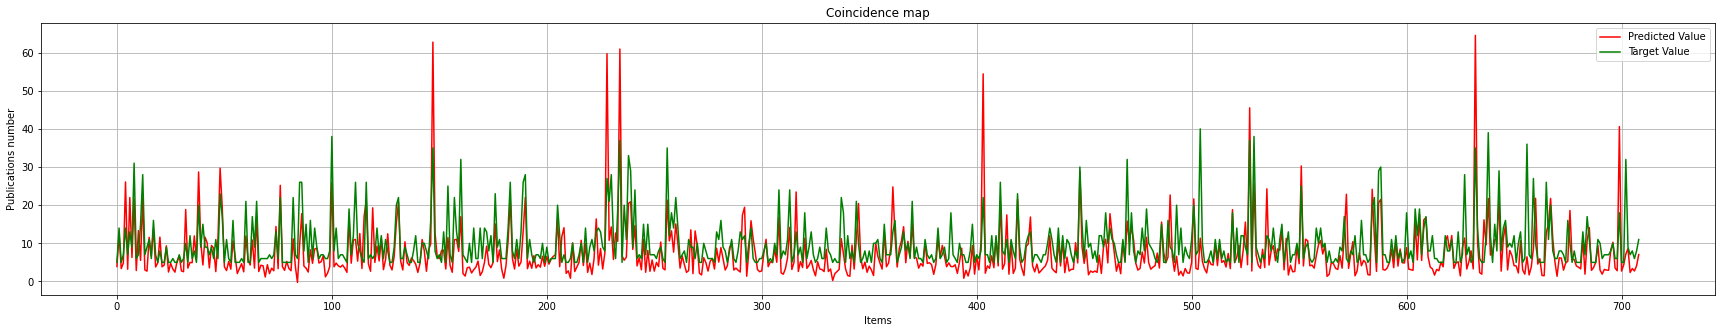

In [7]:
plt.figure(figsize=(30, 5))
plt.plot(xgb_model.predict(X_valid), label="Predicted Value", color="red")
plt.plot(y_valid, label="Target Value", color="green")
plt.ylabel("Publications number")
plt.xlabel("Items")
plt.grid(True)
plt.title("Сoincidence map")
plt.legend()
plt.show()